<h1>光頭傑夫製作</h1><img src="https://rolqiw.bl.files.1drv.com/y4mYqkObWmQmdJFd8pab8t8m7d_mFhh3_YG63fiAnPaG6gjahHFt0n087pF97x1W2wemm7hd4ZdiPD2OxoPtqcCD_4-Jy-fojnt97kGGWR4Hnq0-9Ny61afd7WVHVTmF_9pcr45OFDFSwLKByeQU1q9TjwKk-HsNmWVsW1eGQ4Gi-9G4pQ5DYoTxswYJ5r5dLF-kKsA1InEyrqmV3kF5pm4WQ?width=658&height=584&cropmode=none" width=160px align="left" />

### <span style="color:red ">以下是我們需要的量化分析套件:
---    
    1. Jupyter Notebook環境中，第一次安裝過就好，以後直接導入模組就好。
    2. 如果你是在Colab的環境中運作檔案，請每次安裝

! pip install backtrader

### <span style="color:red ">以下是我們後續輸出分析結果需要的方程式:
---    
    1. 每次你要輸出策略的績效結果時，下面這格你都要跑

In [1]:
def printTradeAnalysis(analyzer):
    '''
    Function to print the Technical Analysis results in a nice format.
    '''
    #Get the results we are interested in
    total_closed = ''
    total_won =''
    total_lost =''
    win_streak = ''
    lose_streak = ''
    pnl_net =''
    strike_rate =''
    
    if len(analyzer.total)>2:
        total_closed = analyzer.total.closed
        total_won = analyzer.won.total
        total_lost = analyzer.lost.total
        win_streak = analyzer.streak.won.longest
        lose_streak = analyzer.streak.lost.longest
        pnl_net = round(analyzer.pnl.net.total,2)
    
    if total_closed:
        strike_rate=round((total_won / total_closed) * 100,2)
    else:
        strike_rate='沒有完整交易'
    print("策略運作分析結果:")
    print(f'獲利累積次數 : {str(total_won)}')
    print(f'損失累積次數 : {str(total_lost)}')
    print(f'獲利損失次數比 : {str(strike_rate)}')
    print(f'最高連續獲利交易次數 : {str(win_streak)}')
    print(f'最高連續損失交易次數 : {str(lose_streak)}')
    print(f'淨利結算 : {str(pnl_net)}')
    

## <span style="color:red ">  <策略1-with Commision>用RSI，來做個簡單的回測策略吧!
---
### 先回想一下，你還記的20-day RSI是什麼意思嗎?
    
    我們測定策略如下:
    1.如果今天的20-day RSI<20，那我們就買進一張的股票。
    2.如果今天的20-day RSI>80，那我們就賣掉一張的股票。
    3.任何時候，我們手上最多就一張股票。
    
    

### <span style="color:red "><策略1.1- with Commision>導入需求模組

In [2]:
from datetime import datetime
import pandas as pd
import yfinance as yf
import backtrader as bt

### <span style="color:red "><策略1.2- with Commision>建立交易策略

In [12]:
class RsiStrategy(bt.Strategy):
    params = dict(
        ma_period=12,
        rsi_uplimit=60,
        rsi_downlimit=25,
    )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

        # add a simple rsi indicator
        self.rsi = bt.indicators.RSI_Safe(self.data.close, period=self.params.ma_period)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'買單執行 --- 買價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'賣單執行 --- 賣價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'運作結果 --- 獲利狀況: {trade.pnl:.2f}, 淨獲利: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.rsi < self.params.rsi_downlimit:
                self.log(f'開出買單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.buy(size=1000)
        else:
            # sell condition
            if self.rsi > self.params.rsi_uplimit:
                self.log(f'開出賣單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.sell(size=1000)

### <span style="color:red "><策略1.3- with Commision>抓取目標股票的歷史資料

In [4]:
data= yf.download(  '2330.tw',              #股票代碼
                    start='2022-3-30',      #資料開始日期
                    end='2023-3-30',         #資料結束日期
                    progress=False
                 )
print(data)
data=bt.feeds.PandasData(dataname=pd.DataFrame({'open': data['Open'], 
                   'high': data['High'],
                   'low': data['Low'],
                   'close': data['Close'],
                   'volume': data['Volume'],
                  }))

             Open   High    Low  Close   Adj Close    Volume
Date                                                        
2022-03-30  599.0  600.0  597.0  600.0  586.769043  41230239
2022-03-31  602.0  602.0  594.0  597.0  583.835144  22700114
2022-04-01  585.0  589.0  584.0  589.0  576.011597  29732696
2022-04-06  578.0  580.0  575.0  578.0  565.254150  37645873
2022-04-07  571.0  573.0  566.0  566.0  553.518799  42904743
...           ...    ...    ...    ...         ...       ...
2023-03-22  524.0  533.0  524.0  533.0  533.000000  42385987
2023-03-23  528.0  539.0  528.0  538.0  538.000000  26728246
2023-03-24  536.0  539.0  535.0  539.0  539.000000  21926240
2023-03-27  533.0  536.0  531.0  531.0  531.000000  16111177
2023-03-28  525.0  530.0  524.0  525.0  525.000000  17234120

[243 rows x 6 columns]


### <span style="color:red "><策略1.4- with Commision>建立台股交易費用計算模式

In [5]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略1.5- with Commision>建立回測分析「大腦」

In [13]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

# create a Cerebro entity
cerebro = bt.Cerebro()

# set up the backtest
cerebro.adddata(data)
cerebro.broker.setcash(cash)
cerebro.addstrategy(RsiStrategy)

#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)

cerebro.broker.addcommissioninfo(comminfo)


### <span style="color:red "><策略1.6- with Commision>讓Analyzers來幫我診斷策略細節...-開始回測

In [14]:
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")

strategies = cerebro.run()
firstStrat = strategies[0]

# print the analyzers
printTradeAnalysis(firstStrat.analyzers.ta.get_analysis())
print(f'持有資產總值: {cerebro.broker.getvalue():.2f}')

2022-04-25, 開出買單 --- 當時市場價格: 547.00
2022-04-26, 買單執行 --- 買價: 550.00, 成本: 550000.00, 手續費: 156.75
2022-05-31, 開出賣單 --- 當時市場價格: 560.00
2022-06-01, 賣單執行 --- 賣價: 550.00, 成本: 550000.00, 手續費: 1806.75
2022-06-01, 運作結果 --- 獲利狀況: 0.00, 淨獲利: -1963.50
2022-07-01, 開出買單 --- 當時市場價格: 453.50
2022-07-04, 買單執行 --- 買價: 443.00, 成本: 443000.00, 手續費: 126.25
2022-07-29, 開出賣單 --- 當時市場價格: 509.00
2022-08-01, 賣單執行 --- 賣價: 506.00, 成本: 443000.00, 手續費: 1662.21
2022-08-01, 運作結果 --- 獲利狀況: 63000.00, 淨獲利: 61211.54
2022-09-30, 開出買單 --- 當時市場價格: 422.00
2022-10-03, 買單執行 --- 買價: 418.50, 成本: 418500.00, 手續費: 119.27
2022-11-11, 開出賣單 --- 當時市場價格: 441.50
2022-11-14, 賣單執行 --- 賣價: 450.00, 成本: 418500.00, 手續費: 1478.25
2022-11-14, 運作結果 --- 獲利狀況: 31500.00, 淨獲利: 29902.48
策略運作分析結果:
獲利累積次數 : 2
損失累積次數 : 1
獲利損失次數比 : 66.67
最高連續獲利交易次數 : 2
最高連續損失交易次數 : 1
淨利結算 : 89150.51
持有資產總值: 1089150.51


### <span style="color:red "><策略1.7- with Commision>畫張圖勝過千言萬語!-圖形化表達

<IPython.core.display.Javascript object>


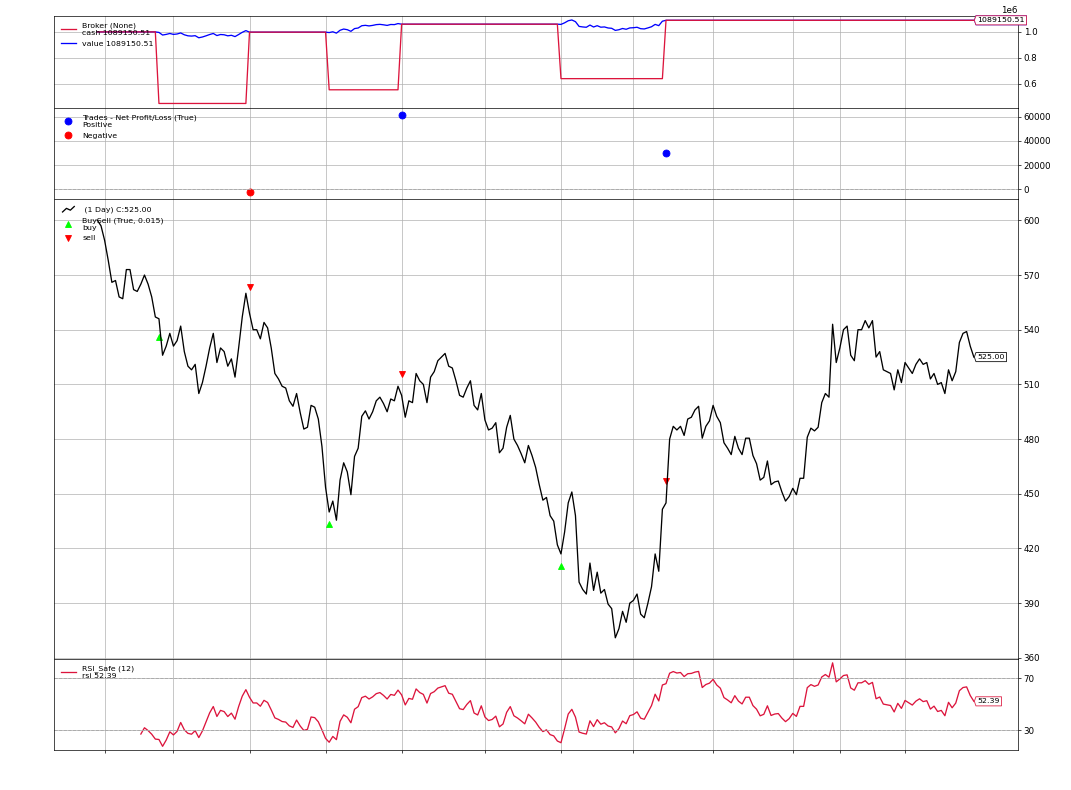

[[<Figure size 320x240 with 4 Axes>]]

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.dpi']=50
# plot results
cerebro.plot(iplot=True, volume=False)

### <span style="color:red "><策略2- with Commision>我們不得不懷疑20-day RSI是一個好選擇嗎?甚至80/20的上下限，那到底是什麼鬼話?
--------
    

### <span style="color:red "><策略2.2- with Commision>建立交易策略

In [9]:
class RsiStrategy(bt.Strategy):
    params = dict(
        ma_period=20, 
        rsi_uplimit=80,
        rsi_downlimit=20,
        totalValue=''
    )

    def __init__(self):
        # keep track of close price in the series
        self.data_close = self.datas[0].close

        # keep track of pending orders
        self.order = None
        self.price = None
        self.comm = None

        # add a simple moving average indicator
        self.rsi = bt.indicators.RSI_Safe(self.data.close, period=self.params.ma_period)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        # set no pending order
        self.order = None

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return
                
        # check if there is already a position
        if not self.position:
            # buy condition
            if self.rsi < self.params.rsi_downlimit:
                self.order = self.buy(size=1000)
        else:
            # sell condition
            if self.rsi > self.params.rsi_uplimit:
                self.order = self.sell(size=1000)

    def stop(self):
        self.log(f'(RSI週期設定 = {self.params.ma_period:2d} RSI上限設定 = {self.params.rsi_uplimit:2d} RSI下限設定 = {self.params.rsi_downlimit:2d}) --- 淨利數值: {self.broker.getvalue()-cash:.2f}')
        self.params.totalValue=self.broker.getvalue()


### <span style="color:red "><策略2.4- with Commision>建立台股交易費用計算模式

In [10]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略2.5- with Commision >建立回測分析「大腦」,讓Analyzers來幫我診斷策略細節...-開始回測

In [11]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

# create a Cerebro entity
cerebro = bt.Cerebro()
cerebro.optstrategy(RsiStrategy, ma_period=range(3, 16),rsi_uplimit=[60,65,70,75,80],rsi_downlimit=[10,15,20,25,30])
cerebro.adddata(data)
cerebro.broker.setcash(cash)



#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)


cerebro.broker.addcommissioninfo(comminfo)

cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name="ta")

opt_runs = cerebro.run(maxcpus=1)


for run in opt_runs:
    for strategy in run:
        print(f'RSI週期設定 = {strategy.params.ma_period:2d} RSI上限設定 = {strategy.params.rsi_uplimit:2d} RSI下限設定 = {strategy.params.rsi_downlimit:2d}')
        try:
            printTradeAnalysis(strategy.analyzers.ta.get_analysis())
        except KeyError :
            print('沒有交易發生')
        print(f'持有資產總值: {strategy.params.totalValue:.2f}')
        print('--------------------------------------------------------')

2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 60 RSI下限設定 = 10) --- 淨利數值: 7657.83
2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 60 RSI下限設定 = 15) --- 淨利數值: -18763.58
2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 60 RSI下限設定 = 20) --- 淨利數值: -31879.12
2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 60 RSI下限設定 = 25) --- 淨利數值: -71390.38
2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 60 RSI下限設定 = 30) --- 淨利數值: -41408.83
2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 65 RSI下限設定 = 10) --- 淨利數值: -47573.42
2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 65 RSI下限設定 = 15) --- 淨利數值: -104247.50
2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 65 RSI下限設定 = 20) --- 淨利數值: -109094.05
2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 65 RSI下限設定 = 25) --- 淨利數值: -119096.90
2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 65 RSI下限設定 = 30) --- 淨利數值: -86591.01
2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 70 RSI下限設定 = 10) --- 淨利數值: -60632.04
2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 70 RSI下限設定 = 15) --- 淨利數值: -135359.04
2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 70 RSI下限設定 = 20) --- 淨利數值: -129241.72
2023-03-28, (RSI週期設定 =  3 RSI上限設定 = 70 RSI下限設定 =

2023-03-28, (RSI週期設定 =  7 RSI上限設定 = 70 RSI下限設定 = 25) --- 淨利數值: -63296.56
2023-03-28, (RSI週期設定 =  7 RSI上限設定 = 70 RSI下限設定 = 30) --- 淨利數值: -54028.44
2023-03-28, (RSI週期設定 =  7 RSI上限設定 = 75 RSI下限設定 = 10) --- 淨利數值: -115638.99
2023-03-28, (RSI週期設定 =  7 RSI上限設定 = 75 RSI下限設定 = 15) --- 淨利數值: -115638.99
2023-03-28, (RSI週期設定 =  7 RSI上限設定 = 75 RSI下限設定 = 20) --- 淨利數值: -115638.99
2023-03-28, (RSI週期設定 =  7 RSI上限設定 = 75 RSI下限設定 = 25) --- 淨利數值: -115638.99
2023-03-28, (RSI週期設定 =  7 RSI上限設定 = 75 RSI下限設定 = 30) --- 淨利數值: -90369.89
2023-03-28, (RSI週期設定 =  7 RSI上限設定 = 80 RSI下限設定 = 10) --- 淨利數值: -74275.32
2023-03-28, (RSI週期設定 =  7 RSI上限設定 = 80 RSI下限設定 = 15) --- 淨利數值: -74275.32
2023-03-28, (RSI週期設定 =  7 RSI上限設定 = 80 RSI下限設定 = 20) --- 淨利數值: -74275.32
2023-03-28, (RSI週期設定 =  7 RSI上限設定 = 80 RSI下限設定 = 25) --- 淨利數值: -74275.32
2023-03-28, (RSI週期設定 =  7 RSI上限設定 = 80 RSI下限設定 = 30) --- 淨利數值: -30068.63
2023-03-28, (RSI週期設定 =  8 RSI上限設定 = 60 RSI下限設定 = 10) --- 淨利數值: 0.00
2023-03-28, (RSI週期設定 =  8 RSI上限設定 = 60 RSI下限設定 = 15)

2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 60 RSI下限設定 = 25) --- 淨利數值: 89150.51
2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 60 RSI下限設定 = 30) --- 淨利數值: 38636.12
2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 65 RSI下限設定 = 10) --- 淨利數值: 0.00
2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 65 RSI下限設定 = 15) --- 淨利數值: 0.00
2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 65 RSI下限設定 = 20) --- 淨利數值: -66678.58
2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 65 RSI下限設定 = 25) --- 淨利數值: -86684.28
2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 65 RSI下限設定 = 30) --- 淨利數值: -106689.97
2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 70 RSI下限設定 = 10) --- 淨利數值: 0.00
2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 70 RSI下限設定 = 15) --- 淨利數值: 0.00
2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 70 RSI下限設定 = 20) --- 淨利數值: -40265.63
2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 70 RSI下限設定 = 25) --- 淨利數值: -60271.33
2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 70 RSI下限設定 = 30) --- 淨利數值: -80277.03
2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 75 RSI下限設定 = 10) --- 淨利數值: 0.00
2023-03-28, (RSI週期設定 = 12 RSI上限設定 = 75 RSI下限設定 = 15) --- 淨利數值: 0.00
2023-03-2

### <span style="color:red "><策略3- with Commision>技術分析不是一直說什麼黃金交叉...什麼死亡交叉...
-----
    1.黃金交叉：短天期均線向上與長天期交叉，稱為黃金交叉。
    2.死亡交叉：短天期均線向下與長天期交叉，稱為死亡交叉。

### <span style="color:red "><策略3.2- with Commision>建立交易策略

In [19]:
class RsiCross(bt.Strategy):
    params = dict(
        pfast=8,   # 短期均線週期
        pslow=37   # 長期均線週期
    )

    def __init__(self):
        self.data_close = self.datas[0].close
        
        self.order = None
        self.price = None
        self.comm = None

        
        rsi1 = bt.indicators.RSI_Safe(self.datas[0],period=self.p.pfast)  # 短期均線
        rsi2 = bt.indicators.RSI_Safe(self.datas[0],period=self.p.pslow)  # 長期均線
        self.crossover = bt.ind.CrossOver(rsi1, rsi2)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'買單執行 --- 買價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'賣單執行 --- 賣價: {order.executed.price:.2f}, 成本: {order.executed.value:.2f}, 手續費: {order.executed.comm:.2f}')

        # report failed order
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失敗')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        self.log(f'運作結果 --- 獲利狀況: {trade.pnl:.2f}, 淨獲利: {trade.pnlcomm:.2f}')

    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.crossover > 0:
                self.log(f'開出買單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.buy(size=1000)
        else:
            # sell condition
            if self.crossover < 0:
                self.log(f'開出賣單 --- 當時市場價格: {self.data_close[0]:.2f}')
                self.order = self.sell(size=1000)
    def stop(self):
        self.log(f'(RSI週期設定 = 短週期:{self.p.pfast:2d},長週期:{self.p.pslow:2d}) --- 最終資產價值: {self.broker.getvalue():.2f}')

### <span style="color:red "><策略3.4- with Commision>建立台股交易費用計算模式

In [20]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略3.5- with Commision>建立回測分析「大腦」

In [21]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

# create a Cerebro entity
cerebro = bt.Cerebro()
cerebro.addstrategy(RsiCross)
cerebro.adddata(data)
cerebro.broker.setcash(cash)



#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)

cerebro.broker.addcommissioninfo(comminfo)



### <span style="color:red "><策略3.6- with Commision>讓Analyzers來幫我診斷策略細節...-開始回測

In [22]:
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")

strategies = cerebro.run()
firstStrat = strategies[0]

# print the analyzers
printTradeAnalysis(firstStrat.analyzers.ta.get_analysis())
print(f'持有資產總值: {firstStrat.broker.getvalue():.2f}')


2022-06-27, 開出買單 --- 當時市場價格: 498.50
2022-06-28, 買單執行 --- 買價: 496.00, 成本: 496000.00, 手續費: 141.36
2022-06-29, 開出賣單 --- 當時市場價格: 491.00
2022-06-30, 賣單執行 --- 賣價: 484.50, 成本: 496000.00, 手續費: 1591.58
2022-06-30, 運作結果 --- 獲利狀況: -11500.00, 淨獲利: -13232.94
2022-07-07, 開出買單 --- 當時市場價格: 457.50
2022-07-08, 買單執行 --- 買價: 470.00, 成本: 470000.00, 手續費: 133.95
2022-08-23, 開出賣單 --- 當時市場價格: 504.00
2022-08-24, 賣單執行 --- 賣價: 504.00, 成本: 470000.00, 手續費: 1655.64
2022-08-24, 運作結果 --- 獲利狀況: 34000.00, 淨獲利: 32210.41
2022-08-26, 開出買單 --- 當時市場價格: 512.00
2022-08-29, 買單執行 --- 買價: 497.00, 成本: 497000.00, 手續費: 141.65
2022-08-29, 開出賣單 --- 當時市場價格: 498.50
2022-08-30, 賣單執行 --- 賣價: 497.50, 成本: 497000.00, 手續費: 1634.29
2022-08-30, 運作結果 --- 獲利狀況: 500.00, 淨獲利: -1275.93
2022-09-13, 開出買單 --- 當時市場價格: 493.00
2022-09-14, 買單執行 --- 買價: 478.50, 成本: 478500.00, 手續費: 136.37
2022-09-14, 開出賣單 --- 當時市場價格: 480.00
2022-09-15, 賣單執行 --- 賣價: 476.00, 成本: 478500.00, 手續費: 1563.66
2022-09-15, 運作結果 --- 獲利狀況: -2500.00, 淨獲利: -4200.03
2022-10-05, 開出買單 --- 當時市

### <span style="color:red "><策略3.7- with Commision>畫張圖勝過千言萬語!-圖形化表達

<IPython.core.display.Javascript object>


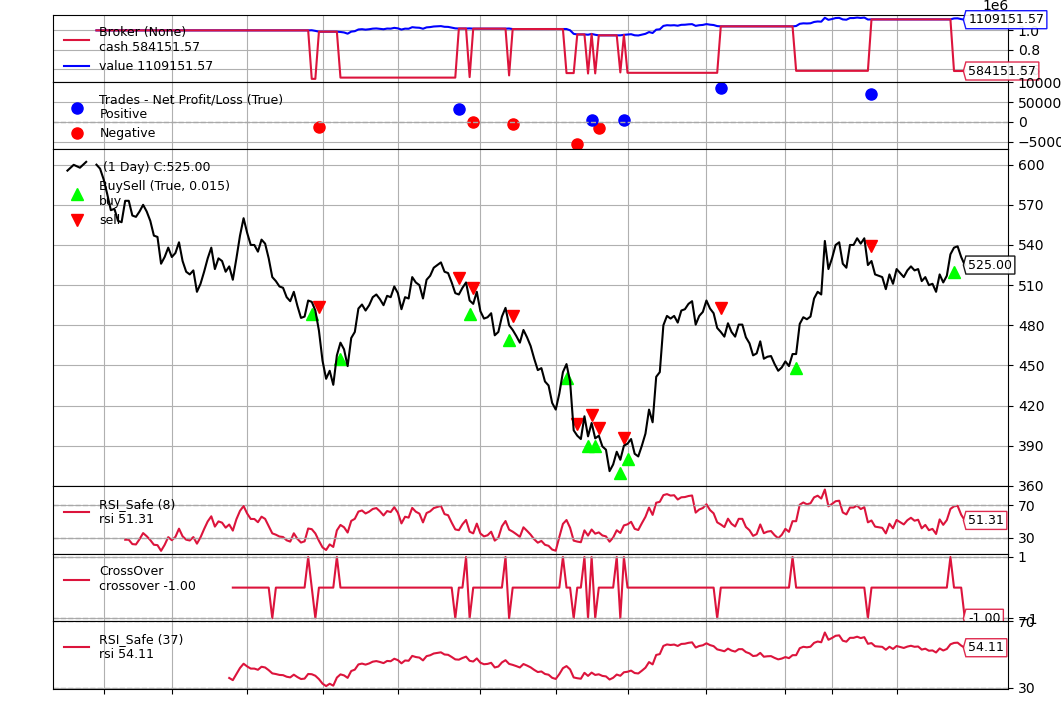

[[<Figure size 512x384 with 6 Axes>]]

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.rcParams['figure.dpi']=80
# plot results
cerebro.plot(iplot=True, volume=False)

### <span style="color:red "><策略4- with Commision>上面是5日線和10日線的交叉結果，那如果我想要知道哪兩條線的配對交叉結果最好...
-----
###     我就是想知道:
        到底是RSI5穿過RSI20比較厲害?
        還是RSI20穿出RSI60比較厲害?

### <span style="color:red "><策略4.2- with Commision>建立交易策略

In [16]:
class RsiCross(bt.Strategy):
    params = dict(
        pfast=5,   # 短期均線週期
        pslow=10,   # 長期均線週期
        totalValue=''
    )

    def __init__(self):
        self.data_close = self.datas[0].close
        
        self.order = None
        self.price = None
        self.comm = None

        
        rsi1 = bt.indicators.RSI_Safe(self.datas[0],period=self.p.pfast)  # 短期均線
        rsi2 = bt.indicators.RSI_Safe(self.datas[0],period=self.p.pslow)  # 長期均線
        self.crossover = bt.ind.CrossOver(rsi1, rsi2)

    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.price = order.executed.price
                self.comm = order.executed.comm

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return


    def next(self):
        # do nothing if an order is pending
        if self.order:
            return

        # check if there is already a position
        if not self.position:
            # buy condition
            if self.crossover > 0:
                self.order = self.buy(size=1000)
        else:
            # sell condition
            if self.crossover < 0:
                self.order = self.sell(size=1000)
    def stop(self):
        self.log(f'(RSI週期設定 = 短週期:{self.p.pfast:2d},長週期:{self.p.pslow:2d}) --- 淨利數值: {self.broker.getvalue()-cash:.2f}')
        self.params.totalValue=self.broker.getvalue()

### <span style="color:red "><策略4.4- with Commision>建立台股交易費用計算模式

In [17]:
class TWStockCommisionScheme(bt.CommInfoBase):
    params = (
        
         ('stocklike', True),
         ('commtype', bt.CommInfoBase.COMM_PERC),
         ('percabs', True),
         ('discount', 0.3),
         ('tax',0.003),
         ('lowestfee',20)
        )

    def _getcommission(self, size, price, pseudoexec):
          if size>0:
            return max(self.p.lowestfee,size * price * self.p.commission * self.p.discount)
          else:
            return (max(self.p.lowestfee,-(size * price * self.p.commission * self.p.discount))-size * price *self.p.tax)

### <span style="color:red "><策略4.5- with Commision>建立回測分析「大腦」,讓Analyzers來幫我診斷策略細節...-開始回測

In [18]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

cerebro = bt.Cerebro()
cerebro.optstrategy(RsiCross, pfast=range(3,21),pslow=range(23,61))
cerebro.adddata(data)
cerebro.broker.setcash(cash)


#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.2,
    tax=0.003,
    lowestfee=20
)


cerebro.broker.addcommissioninfo(comminfo)

cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name="ta")

opt_runs = cerebro.run(maxcpus=1)


for run in opt_runs:
    for strategy in run:
        print(f'RSI短週期設定:{strategy.params.pfast} RSI長週期設定:{strategy.params.pslow}')
        try:
            printTradeAnalysis(strategy.analyzers.ta.get_analysis())
        except KeyError :
            print('沒有交易發生')
        print(f'持有資產總值: {strategy.params.totalValue:.2f}')
        print('--------------------------------------------------------')

2023-03-28, (RSI週期設定 = 短週期: 3,長週期:23) --- 淨利數值: -12345.75
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:24) --- 淨利數值: -12345.75
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:25) --- 淨利數值: -17535.36
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:26) --- 淨利數值: -19528.79
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:27) --- 淨利數值: -8716.24
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:28) --- 淨利數值: -8716.24
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:29) --- 淨利數值: -7852.98
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:30) --- 淨利數值: -7852.98
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:31) --- 淨利數值: -7852.98
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:32) --- 淨利數值: -7852.98
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:33) --- 淨利數值: -7852.98
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:34) --- 淨利數值: -7852.98
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:35) --- 淨利數值: -15956.59
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:36) --- 淨利數值: -15956.59
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:37) --- 淨利數值: -15086.20
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:38) --- 淨利數值: -15086.20
2023-03-28, (RSI週期設定 = 短週期: 3,長週期:39) --- 淨利數值: -14162.25
2023-03-28, (RSI週期設定 =

2023-03-28, (RSI週期設定 = 短週期: 6,長週期:53) --- 淨利數值: 50187.94
2023-03-28, (RSI週期設定 = 短週期: 6,長週期:54) --- 淨利數值: 56952.94
2023-03-28, (RSI週期設定 = 短週期: 6,長週期:55) --- 淨利數值: 56952.94
2023-03-28, (RSI週期設定 = 短週期: 6,長週期:56) --- 淨利數值: 60874.17
2023-03-28, (RSI週期設定 = 短週期: 6,長週期:57) --- 淨利數值: 55684.57
2023-03-28, (RSI週期設定 = 短週期: 6,長週期:58) --- 淨利數值: 55684.57
2023-03-28, (RSI週期設定 = 短週期: 6,長週期:59) --- 淨利數值: 68917.51
2023-03-28, (RSI週期設定 = 短週期: 6,長週期:60) --- 淨利數值: 68917.51
2023-03-28, (RSI週期設定 = 短週期: 7,長週期:23) --- 淨利數值: 63195.97
2023-03-28, (RSI週期設定 = 短週期: 7,長週期:24) --- 淨利數值: 73113.14
2023-03-28, (RSI週期設定 = 短週期: 7,長週期:25) --- 淨利數值: 62149.28
2023-03-28, (RSI週期設定 = 短週期: 7,長週期:26) --- 淨利數值: 62149.28
2023-03-28, (RSI週期設定 = 短週期: 7,長週期:27) --- 淨利數值: 65837.09
2023-03-28, (RSI週期設定 = 短週期: 7,長週期:28) --- 淨利數值: 67747.38
2023-03-28, (RSI週期設定 = 短週期: 7,長週期:29) --- 淨利數值: 83561.36
2023-03-28, (RSI週期設定 = 短週期: 7,長週期:30) --- 淨利數值: 100401.64
2023-03-28, (RSI週期設定 = 短週期: 7,長週期:31) --- 淨利數值: 100401.64
2023-03-28, (RSI週期設定 = 短週期: 7

2023-03-28, (RSI週期設定 = 短週期:10,長週期:45) --- 淨利數值: 53053.42
2023-03-28, (RSI週期設定 = 短週期:10,長週期:46) --- 淨利數值: 53053.42
2023-03-28, (RSI週期設定 = 短週期:10,長週期:47) --- 淨利數值: 53053.42
2023-03-28, (RSI週期設定 = 短週期:10,長週期:48) --- 淨利數值: 46659.70
2023-03-28, (RSI週期設定 = 短週期:10,長週期:49) --- 淨利數值: 46659.70
2023-03-28, (RSI週期設定 = 短週期:10,長週期:50) --- 淨利數值: 49649.84
2023-03-28, (RSI週期設定 = 短週期:10,長週期:51) --- 淨利數值: 49649.84
2023-03-28, (RSI週期設定 = 短週期:10,長週期:52) --- 淨利數值: 80658.68
2023-03-28, (RSI週期設定 = 短週期:10,長週期:53) --- 淨利數值: 81788.85
2023-03-28, (RSI週期設定 = 短週期:10,長週期:54) --- 淨利數值: 81788.85
2023-03-28, (RSI週期設定 = 短週期:10,長週期:55) --- 淨利數值: 81788.85
2023-03-28, (RSI週期設定 = 短週期:10,長週期:56) --- 淨利數值: 81788.85
2023-03-28, (RSI週期設定 = 短週期:10,長週期:57) --- 淨利數值: 81788.85
2023-03-28, (RSI週期設定 = 短週期:10,長週期:58) --- 淨利數值: 81788.85
2023-03-28, (RSI週期設定 = 短週期:10,長週期:59) --- 淨利數值: 95021.80
2023-03-28, (RSI週期設定 = 短週期:10,長週期:60) --- 淨利數值: 95021.80
2023-03-28, (RSI週期設定 = 短週期:11,長週期:23) --- 淨利數值: 60099.70
2023-03-28, (RSI週期設定 = 短週期:11,長

2023-03-28, (RSI週期設定 = 短週期:14,長週期:38) --- 淨利數值: 56588.75
2023-03-28, (RSI週期設定 = 短週期:14,長週期:39) --- 淨利數值: 35780.49
2023-03-28, (RSI週期設定 = 短週期:14,長週期:40) --- 淨利數值: 35780.49
2023-03-28, (RSI週期設定 = 短週期:14,長週期:41) --- 淨利數值: 35780.49
2023-03-28, (RSI週期設定 = 短週期:14,長週期:42) --- 淨利數值: 35780.49
2023-03-28, (RSI週期設定 = 短週期:14,長週期:43) --- 淨利數值: 35780.49
2023-03-28, (RSI週期設定 = 短週期:14,長週期:44) --- 淨利數值: 35780.49
2023-03-28, (RSI週期設定 = 短週期:14,長週期:45) --- 淨利數值: 33664.31
2023-03-28, (RSI週期設定 = 短週期:14,長週期:46) --- 淨利數值: 32169.23
2023-03-28, (RSI週期設定 = 短週期:14,長週期:47) --- 淨利數值: 36296.70
2023-03-28, (RSI週期設定 = 短週期:14,長週期:48) --- 淨利數值: 36296.70
2023-03-28, (RSI週期設定 = 短週期:14,長週期:49) --- 淨利數值: 31174.92
2023-03-28, (RSI週期設定 = 短週期:14,長週期:50) --- 淨利數值: 31174.92
2023-03-28, (RSI週期設定 = 短週期:14,長週期:51) --- 淨利數值: 31174.92
2023-03-28, (RSI週期設定 = 短週期:14,長週期:52) --- 淨利數值: 31174.92
2023-03-28, (RSI週期設定 = 短週期:14,長週期:53) --- 淨利數值: 31174.92
2023-03-28, (RSI週期設定 = 短週期:14,長週期:54) --- 淨利數值: 31174.92
2023-03-28, (RSI週期設定 = 短週期:14,長

2023-03-28, (RSI週期設定 = 短週期:18,長週期:30) --- 淨利數值: 20001.60
2023-03-28, (RSI週期設定 = 短週期:18,長週期:31) --- 淨利數值: 18506.52
2023-03-28, (RSI週期設定 = 短週期:18,長週期:32) --- 淨利數值: 18506.52
2023-03-28, (RSI週期設定 = 短週期:18,長週期:33) --- 淨利數值: 10908.41
2023-03-28, (RSI週期設定 = 短週期:18,長週期:34) --- 淨利數值: 5786.63
2023-03-28, (RSI週期設定 = 短週期:18,長週期:35) --- 淨利數值: 5786.63
2023-03-28, (RSI週期設定 = 短週期:18,長週期:36) --- 淨利數值: 8608.23
2023-03-28, (RSI週期設定 = 短週期:18,長週期:37) --- 淨利數值: 8608.23
2023-03-28, (RSI週期設定 = 短週期:18,長週期:38) --- 淨利數值: 8608.23
2023-03-28, (RSI週期設定 = 短週期:18,長週期:39) --- 淨利數值: 10735.12
2023-03-28, (RSI週期設定 = 短週期:18,長週期:40) --- 淨利數值: 15492.42
2023-03-28, (RSI週期設定 = 短週期:18,長週期:41) --- 淨利數值: -8496.58
2023-03-28, (RSI週期設定 = 短週期:18,長週期:42) --- 淨利數值: -8496.58
2023-03-28, (RSI週期設定 = 短週期:18,長週期:43) --- 淨利數值: -8496.58
2023-03-28, (RSI週期設定 = 短週期:18,長週期:44) --- 淨利數值: 27643.57
2023-03-28, (RSI週期設定 = 短週期:18,長週期:45) --- 淨利數值: 40600.87
2023-03-28, (RSI週期設定 = 短週期:18,長週期:46) --- 淨利數值: 40600.87
2023-03-28, (RSI週期設定 = 短週期:18,長週期:47

In [41]:
#設立投資本金
#你可以根據你想要模擬的投資標的股價作適當調整
cash=1000000

cerebro = bt.Cerebro()
cerebro.optstrategy(RsiCross, pfast=[5,6,7],pslow=[21,22,23,24,25,26,27,28,29,30])
cerebro.adddata(data)
cerebro.broker.setcash(cash)


#commission手續費 0.1425%
#discount 你可以拿到的手續費折數
#tax=0.003 證券交易稅率
comminfo = TWStockCommisionScheme(
    commission=0.001425,  
    discount=0.5,
    tax=0.003,
    lowestfee=20
)


cerebro.broker.addcommissioninfo(comminfo)

cerebro.addanalyzer(bt.analyzers.TradeAnalyzer,_name="ta")

opt_runs = cerebro.run(maxcpus=1)


for run in opt_runs:
    for strategy in run:
        print(f'RSI短週期設定:{strategy.params.pfast} RSI長週期設定:{strategy.params.pslow}')
        try:
            printTradeAnalysis(strategy.analyzers.ta.get_analysis())
        except KeyError :
            print('沒有交易發生')
        print(f'持有資產總值: {strategy.params.totalValue:.2f}')
        print('--------------------------------------------------------')

2021-11-16, (RSI週期設定 = 短週期: 5,長週期:21) --- 淨利數值: 73628.75
2021-11-16, (RSI週期設定 = 短週期: 5,長週期:22) --- 淨利數值: 77962.59
2021-11-16, (RSI週期設定 = 短週期: 5,長週期:23) --- 淨利數值: 78989.28
2021-11-16, (RSI週期設定 = 短週期: 5,長週期:24) --- 淨利數值: 75302.82
2021-11-16, (RSI週期設定 = 短週期: 5,長週期:25) --- 淨利數值: 66254.63
2021-11-16, (RSI週期設定 = 短週期: 5,長週期:26) --- 淨利數值: 68907.99
2021-11-16, (RSI週期設定 = 短週期: 5,長週期:27) --- 淨利數值: 68907.99
2021-11-16, (RSI週期設定 = 短週期: 5,長週期:28) --- 淨利數值: 68907.99
2021-11-16, (RSI週期設定 = 短週期: 5,長週期:29) --- 淨利數值: 67229.10
2021-11-16, (RSI週期設定 = 短週期: 5,長週期:30) --- 淨利數值: 67229.10
2021-11-16, (RSI週期設定 = 短週期: 6,長週期:21) --- 淨利數值: 82919.38
2021-11-16, (RSI週期設定 = 短週期: 6,長週期:22) --- 淨利數值: 94515.62
2021-11-16, (RSI週期設定 = 短週期: 6,長週期:23) --- 淨利數值: 94515.62
2021-11-16, (RSI週期設定 = 短週期: 6,長週期:24) --- 淨利數值: 91895.89
2021-11-16, (RSI週期設定 = 短週期: 6,長週期:25) --- 淨利數值: 92589.18
2021-11-16, (RSI週期設定 = 短週期: 6,長週期:26) --- 淨利數值: 90606.53
2021-11-16, (RSI週期設定 = 短週期: 6,長週期:27) --- 淨利數值: 90606.53
2021-11-16, (RSI週期設定 = 短週期: 6,長